In [1]:
import mysql.connector
import pandas as pd
import requests
import numpy as np
from datetime import datetime
from datetime import timezone
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from google.cloud import bigquery



In [4]:
client = bigquery.Client()

db = mysql.connector.connect(
   host="localhost",
   user="root",
   passwd="root",
   database='divy'
)
print(db)

In [8]:
sql="""SELECT STR_TO_DATE(start_time, '%m/%d/%Y') as dt , count(trip_id) as ridecount
FROM divy.divvy_trips_raw
GROUP BY dt"""
df = pd.read_sql(sql, con=db)

In [9]:
df.head()

,dt,ridecount
0,None,1
1,2017-01-01,1727
2,2017-01-02,1960
3,2017-01-03,4537
4,2017-01-04,3269


In [12]:
df['dt']=pd.to_datetime(df['dt'])
df['dt']=pd.DatetimeIndex(pd.to_datetime(df['dt'],unit='ms')).tz_localize('UTC')
df.head()


,dt,ridecount
0,NaT,1
1,2017-01-01 00:00:00+00:00,1727
2,2017-01-02 00:00:00+00:00,1960
3,2017-01-03 00:00:00+00:00,4537
4,2017-01-04 00:00:00+00:00,3269


In [7]:
sql="""SELECT
    TIMESTAMP_TRUNC(TIMESTAMP(CONCAT(year, '-', mo, '-', da)),
      DAY) AS date,
    year,
    PERCENT_RANK() OVER (PARTITION BY year ORDER BY AVG(temp)) AS rank,
    AVG(temp) AS temperature
  FROM
    `bigquery-public-data.noaa_gsod.gsod*` AS w
  JOIN
    `bigquery-public-data.noaa_gsod.stations` AS s
  ON
    w.stn = s.usaf
    AND s.name = "CHICAGO O'HARE INTERNATIONAL"
  WHERE
    w._TABLE_SUFFIX ='2017'
  GROUP BY
    date,
    year"""

weather_df = client.query(sql).to_dataframe()
weather_df.head()

,date,year,rank,temperature
0,2017-12-31 00:00:00+00:00,2017,0.000000,0.4
1,2017-12-27 00:00:00+00:00,2017,0.002747,1.1
2,2017-12-26 00:00:00+00:00,2017,0.005495,2.5
3,2017-01-06 00:00:00+00:00,2017,0.008242,4.4
4,2017-12-28 00:00:00+00:00,2017,0.010989,6.2


In [13]:
merged_data = pd.merge(df, weather_df, left_on='dt', right_on='date')
merged_data.head()

,dt,ridecount,date,year,rank,temperature
0,2017-01-01 00:00:00+00:00,1727,2017-01-01 00:00:00+00:00,2017,0.101648,27.4
1,2017-01-02 00:00:00+00:00,1960,2017-01-02 00:00:00+00:00,2017,0.173077,34.0
2,2017-01-03 00:00:00+00:00,4537,2017-01-03 00:00:00+00:00,2017,0.241758,38.2
3,2017-01-04 00:00:00+00:00,3269,2017-01-04 00:00:00+00:00,2017,0.030220,18.2
4,2017-01-05 00:00:00+00:00,2917,2017-01-05 00:00:00+00:00,2017,0.019231,9.3


Text(0.5,0,'Temperature')

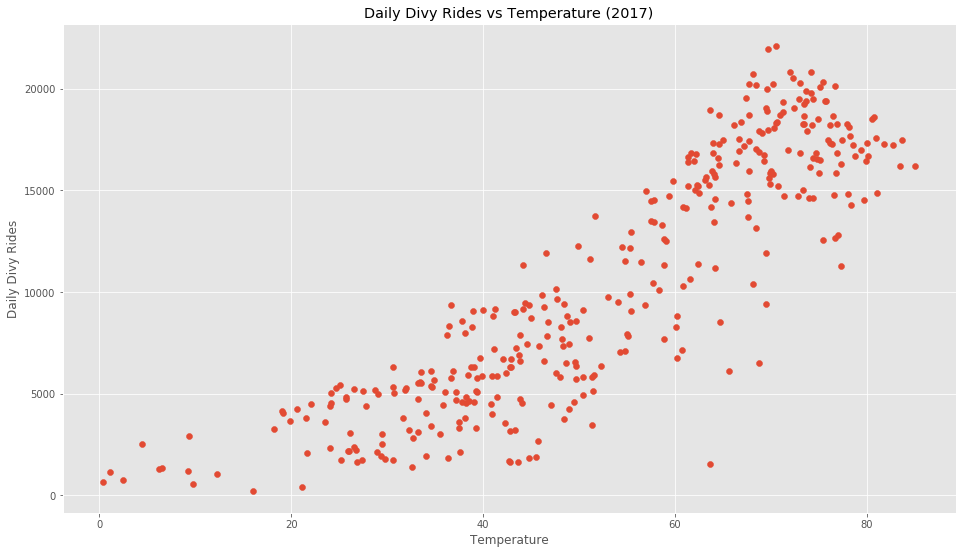

In [14]:
fig = plt.figure(figsize=(16,9))
plt.scatter(merged_data['temperature'],merged_data['ridecount'])
plt.title('Daily Divy Rides vs Temperature (2017)')
plt.ylabel("Daily Divy Rides")
plt.xlabel("Temperature")

In [15]:
plt.savefig("divy.png")

<Figure size 432x288 with 0 Axes>